# Support vector machine classifier with $\ell_1$-regularization

In this example we use CVXPY to train a SVM classifier with $\ell_1$-regularization.
We are given data $(x_i,y_i)$, $i=1,\ldots, m$. The $x_i \in {\bf R}^n$ are feature vectors, while the $y_i \in \{\pm 1\}$ are associated boolean outcomes.
Our goal is to construct a good linear classifier $\hat y = {\rm sign}(\beta^T x - v)$.
We find the parameters $\beta,v$ by minimizing the (convex) function

$$
f(\beta,v) = (1/m) \sum_i \left(1 - y_i ( \beta^T x_i-v) \right)_+ + \lambda
\| \beta\|_1
$$

The first term is the average hinge loss. The second term shrinks the coefficients in $\beta$ and encourages sparsity.
The scalar $\lambda \geq 0$ is a (regularization) parameter.
Minimizing $f(\beta,v)$  simultaneously selects features and fits the classifier.

### Example

In the following code we generate data with $n=20$ features by randomly choosing $x_i$ and a sparse $\beta_{\mathrm{true}} \in {\bf R}^n$.
We then set $y_i = {\rm sign}(\beta_{\mathrm{true}}^T x_i -v_{\mathrm{true}} - z_i)$, where the $z_i$ are i.i.d. normal random variables.
We divide the data into training and test sets with $m=1000$ examples each.

In [1]:
# Generate data for SVM classifier with L1 regularization.
from __future__ import division
import numpy as np
np.random.seed(1)
n = 20
m = 1000
TEST = m
DENSITY = 0.2
beta_true = np.random.randn(n,1)
idxs = np.random.choice(range(n), int((1-DENSITY)*n), replace=False)
for idx in idxs:
    beta_true[idx] = 0
offset = 0
sigma = 45
X = np.random.normal(0, 5, size=(m,n))
Y = np.sign(X.dot(beta_true) + offset + np.random.normal(0,sigma,size=(m,1)))
X_test = np.random.normal(0, 5, size=(TEST,n))
Y_test = np.sign(X_test.dot(beta_true) + offset + np.random.normal(0,sigma,size=(TEST,1)))

We next formulate the optimization problem using CVXPY.

In [5]:
# Form SVM with L1 regularization problem.
import cvxpy as cvx
beta = cvx.Variable(n)
v = cvx.Variable()
loss = cvx.sum(cvx.pos(1 - cvx.multiply(Y.flatten(), X*beta - v)))
reg = cvx.norm(beta, 1)
lambd = cvx.Parameter(nonneg=True)
prob = cvx.Problem(cvx.Minimize(loss/m + lambd*reg))

We solve the optimization problem for a range of $\lambda$ to compute a trade-off curve.
We then plot the train and test error over the trade-off curve.
A reasonable choice of $\lambda$ is the value that minimizes the test error.

In [6]:
# Compute a trade-off curve and record train and test error.
TRIALS = 100
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-2, 0, TRIALS)
beta_vals = []
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve()
    train_error[i] = (np.sign(X.dot(beta_true) + offset) != np.sign(X.dot(beta.value) - v.value)).sum()/m
    test_error[i] = (np.sign(X_test.dot(beta_true) + offset) != np.sign(X_test.dot(beta.value) - v.value)).sum()/TEST
    beta_vals.append(beta.value)

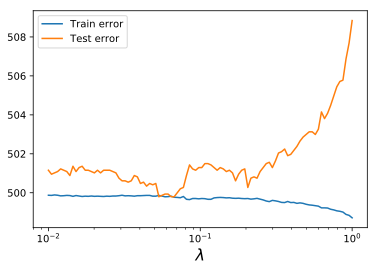

In [7]:
# Plot the train and test error over the trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()

We also plot the regularization path, or the $\beta_i$ versus $\lambda$. Notice that the $\beta_i$ do not necessarily decrease monotonically as $\lambda$ increases.
4 features remain non-zero longer for larger $\lambda$ then the rest, which suggests that these features are the most important. In fact $\beta_{\mathrm{true}}$ had 4 non-zero values.

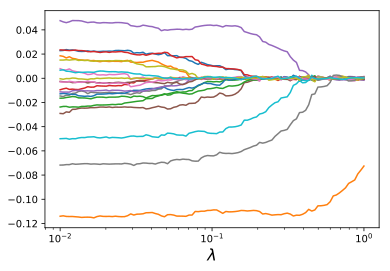

In [13]:
# Plot the regularization path for beta.
for i in range(n):
    plt.plot(lambda_vals, [wi[i] for wi in beta_vals])
plt.xlabel(r"$\lambda$", fontsize=16)
plt.xscale("log")